# Decision Tree

In [291]:
# Kerakli kutubxonalarni yuklab olamiz
######################################################

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

######################################################

In [611]:
# Kerakli malumotlarni make_regression orqali yaratib olamiz
######################################################

X, y = make_regression(n_samples = 500, n_features =10)
X_train, X_test, y_train, y_test = train_test_split(X, y) #, test_size=0.2

######################################################

In [612]:
y

array([-3.73913199e+01,  4.67795566e+01,  1.09882794e+01,  5.42964666e+01,
        2.10065831e+01, -1.16358634e+02,  5.61401937e+01,  1.16850083e+02,
        6.88788746e+01,  6.23802788e+01,  2.37731903e+02, -3.86205925e+02,
       -4.96678762e+01,  1.13001114e+02, -1.20306951e+02,  1.49233714e+02,
       -7.18210224e+01, -2.04101611e+02, -2.52429957e+02,  1.94914555e+02,
       -2.18858077e+02, -3.63491904e+01, -1.25491000e+02, -1.55007347e+01,
       -1.72337446e+02,  1.46007194e+02,  1.38115819e+02, -2.22319074e+02,
       -1.72920155e+02, -1.53495526e+02,  1.42163862e+02,  5.79143463e+01,
        1.46830287e+02,  1.01769167e+02, -1.03850239e+02,  2.15283123e+02,
       -1.31826884e+02, -2.38461068e+02, -6.65156872e+01,  8.08580269e+01,
        1.75164101e+02,  1.44397195e+02, -5.90968154e+01, -2.28197211e+02,
       -1.71806268e+02, -5.44918719e+01,  8.16039611e+01,  5.79720829e+01,
       -1.10412246e+02,  4.82867422e+00, -5.96501477e+01, -2.18723345e+02,
       -9.76335526e+01,  

## Node

In [613]:
# Daraxtni tugunini yaratib olamiz Node
######################################################

class Node:
    
    def __init__(self, feature = None, treshold = None, left = None, right = None, *, model = None):
        self.feature = feature # belgilar, predicatlar
        self.treshold = treshold # chegara
        self.left = left
        self.right = right
        self.model = model
    
    # Quyida keltirilgan metod --True qaytaradi agar --value none bo'lmasa, aks holda --False
    def is_leaf_node(self):
        return self.model is not None
    
######################################################

In [614]:
from sklearn.neighbors import KNeighborsRegressor


## Tree

In [615]:
# Daraxtni ozini yaratib olami
######################################################

class DecisionTree:
    def __init__(self, max_depth = 3, min_sample = 10, prop_impurity = 'mae'):
        self.max_depth = max_depth
        self.min_sample = min_sample
        self.prop_impurity = prop_impurity
        self.tree = []
    
    # o'rgatish metodini yaratib olamiz.
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    # bashorat qilish metodi
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    # bashoratning o'rtacha qiymatini qaytarish metodi
    def avarage(self, X, y):
        neigh = KNeighborsRegressor(n_neighbors=len(X), weights='distance')
        return neigh.fit(X,y)
    
    # ma'lumotni foydalalilik darajasini aniqlash metodi
    def impurity(self, y):
        predict = np.sum(y) / len(y)
        mse = np.sum((predict - y) ** 2) / len(y)
        mae = np.sum(np.abs(predict - y)) / len(y)
        return mae if self.prop_impurity == 'mae' else mse
    
    # ma'lumotni yaxshi belgi bo'yicha bo'lish
    def split(self, X, y):
        best_feature, best_treshold = None, None
        best_gain = -1
        
        # har bir unikal belgini olib uni ichidan yaxshisini tanlab olamiz 
        # bu belgi shart sifatida qo'llaniladi.
        
        for col in range(X.shape[1]):
            tresholds = np.unique(X[:, col])
            for treshold in tresholds:
                gain = self.information_gain(X[:, col], y, treshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = col
                    best_treshold = treshold
                    
        return best_feature, best_treshold
       
    #malumotning yaroqliligi tekshiriladi u qancha Q >> kata bo'la shuncha yaxshi.   
    def information_gain(self, X_featch, y, treshold):
        
        h_m, h_l, h_r = 0, 0, 0
        
        # Umumiy axborotni foydaliligini hisoblaymiz
        h_m = self.impurity(y)
        
        # ma'lumotlarni shart boyicha taqqoslab uning indexlarini left va right ro'yxatga yozib olamiz.
        left_indexes = np.argwhere(X_featch <= treshold).flatten()
        right_indexes = np.argwhere(X_featch > treshold).flatten()
    
        
        if len(left_indexes):
            h_l = (len(left_indexes)/len(y)) * self.impurity(y[left_indexes])
        else:
            h_l = 0
        
       
            
        if len(right_indexes):
            h_r = (len(right_indexes)/len(y)) * self.impurity(y[right_indexes])
        else:
            h_r = 0
        
        return h_m - h_l - h_r
    
    # Daraxtni yaratamiz.        
    def grow_tree(self, X, y, depth = 0):
        
        n_samples = X.shape[0]
        
        if n_samples <= self.min_sample or depth >= self.max_depth:
            return Node(model = self.avarage(X, y))
       
        best_feature, best_treshold = self.split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_treshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_treshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return Node(model = self.avarage(X, y))
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_treshold, left, right)
    
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.model
        if x[tree.feature] <= tree.treshold:
            return self.travers_tree(x, tree.left)
        return self.travers_tree(x, tree.right)
        
######################################################

In [616]:

clf = DecisionTree()
clf.fit(X_train, y_train)


In [617]:
models = clf.predict(X_test)

In [618]:
pred = []
for i in range(len(models)):
    pred.append((models[i].predict([X_test[i]])))
pred = np.array(pred)
pred = pred.flatten()


In [619]:
1 - np.sum((pred - y_test)**2) / np.sum((y_test.mean() - y_test)**2)

0.3800828417862764

In [627]:
DecisionTreeRegressor?

[Text(0.5, 0.875, 'x[2] <= 0.29\nsquared_error = 23019.694\nsamples = 375\nvalue = -4.601'),
 Text(0.25, 0.625, 'x[9] <= -0.061\nsquared_error = 16987.726\nsamples = 221\nvalue = -69.543'),
 Text(0.125, 0.375, 'x[3] <= 1.003\nsquared_error = 14078.374\nsamples = 114\nvalue = -132.069'),
 Text(0.0625, 0.125, 'squared_error = 10341.051\nsamples = 97\nvalue = -156.641'),
 Text(0.1875, 0.125, 'squared_error = 12300.843\nsamples = 17\nvalue = 8.135'),
 Text(0.375, 0.375, 'x[3] <= 0.47\nsquared_error = 11484.291\nsamples = 107\nvalue = -2.926'),
 Text(0.3125, 0.125, 'squared_error = 9088.206\nsamples = 78\nvalue = -35.017'),
 Text(0.4375, 0.125, 'squared_error = 7709.19\nsamples = 29\nvalue = 83.387'),
 Text(0.75, 0.625, 'x[9] <= -0.143\nsquared_error = 16938.217\nsamples = 154\nvalue = 88.594'),
 Text(0.625, 0.375, 'x[2] <= 1.157\nsquared_error = 10420.973\nsamples = 69\nvalue = -1.229'),
 Text(0.5625, 0.125, 'squared_error = 7510.299\nsamples = 46\nvalue = -37.711'),
 Text(0.6875, 0.125, '

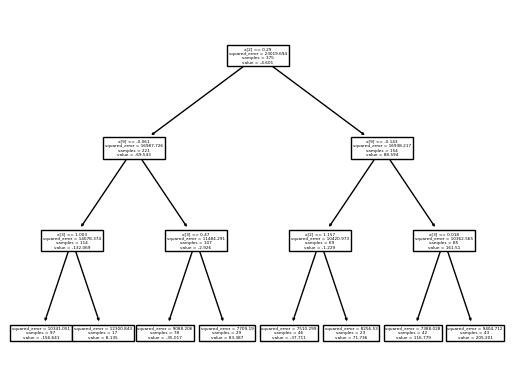

In [628]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

reg = DecisionTreeRegressor(max_depth=3, min_samples_split= 10)
reg.fit(X_train, y_train)

plot_tree(reg)

In [621]:
pred

array([ 201.45874375,   38.05768423, -151.97912876,  -58.79079409,
        115.42194859,  -44.50019382,  116.46798071, -155.55004892,
         37.99021468, -143.53536357,  -60.05115667,  -67.60166752,
        -64.26021187,   41.32507961,  -62.31369219, -157.38866717,
         49.01660687,  196.82789726,  -55.21057569,  188.53230073,
         32.00324359,  -61.33797389,   31.97053547,  106.22459587,
         33.85556711,   38.74865898,  -54.43287332,  -41.66844913,
        110.37800853,   31.46401195, -141.114745  ,   48.9543986 ,
         36.49061911,   43.67845301,   -0.2744462 ,  199.16848654,
        -74.01769059, -150.54442176,   18.73968254,   41.92572   ,
       -151.94506553,  109.33096475, -150.62993344,   38.08676499,
        -67.48604457,  198.99180857,  196.46944879, -154.04328502,
       -151.69054434,  196.59924761, -146.14494647,   33.16945501,
       -148.50362631,  210.68723923, -146.09914395,  -59.23895561,
        -52.50778303,   40.80924638,   41.49483809, -154.02312

In [622]:
pred2

array([-135.10392399,  -69.4721964 , -135.10392399,  171.65792103,
        -69.4721964 ,   60.14308061,  -33.43300473,  -33.43300473,
        -33.43300473,   12.5099632 ,  -33.43300473,  -33.43300473,
        -33.43300473,   79.45435919,  -33.43300473,  171.65792103,
         79.45435919,   79.45435919, -135.10392399,  -33.43300473,
       -233.37445672,  171.65792103,   12.5099632 ,  171.65792103,
        171.65792103,   79.45435919,   60.14308061,   79.45435919,
        -33.43300473,  -33.43300473, -233.37445672,  -69.4721964 ,
        -33.43300473,   60.14308061,   12.5099632 ,   79.45435919,
         12.5099632 ,  -33.43300473,  171.65792103, -233.37445672,
        -33.43300473,   60.14308061,  -33.43300473,  -69.4721964 ,
       -135.10392399, -135.10392399,  -69.4721964 ,   79.45435919,
       -233.37445672,   60.14308061,  -33.43300473, -135.10392399,
         79.45435919,  171.65792103,   12.5099632 ,   60.14308061,
        171.65792103,   79.45435919,  171.65792103,   60.14308

In [586]:
y_test

array([ -73.69305722,  -16.94038151,   40.21653119,   39.86803546,
       -151.34909806,  170.15658949,  -94.5126572 ])

In [629]:
pred2 = reg.predict(X_test)

In [630]:
1 - np.sum((pred2 - y_test)**2) / np.sum((y_test.mean() - y_test)**2)

0.4344093904131585

In [631]:
len(pred)

125

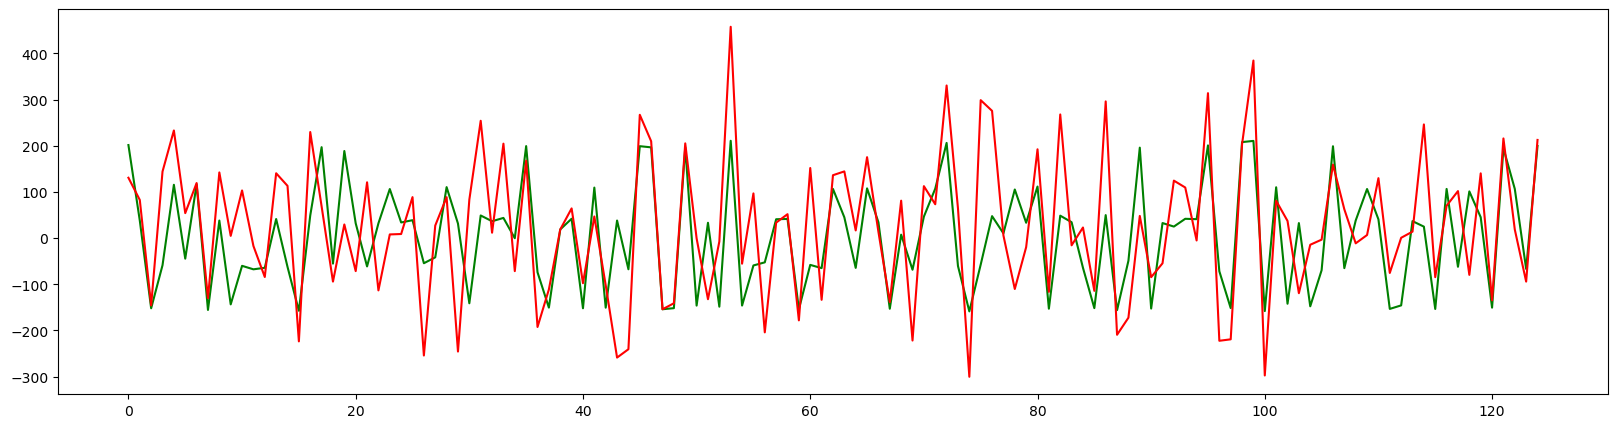

In [632]:
x = [i for i in range(125)]
plt.figure(figsize=(20,5))
plt.plot(x, pred, color='g')
plt.plot(x, y_test, color ='r')
plt.show()

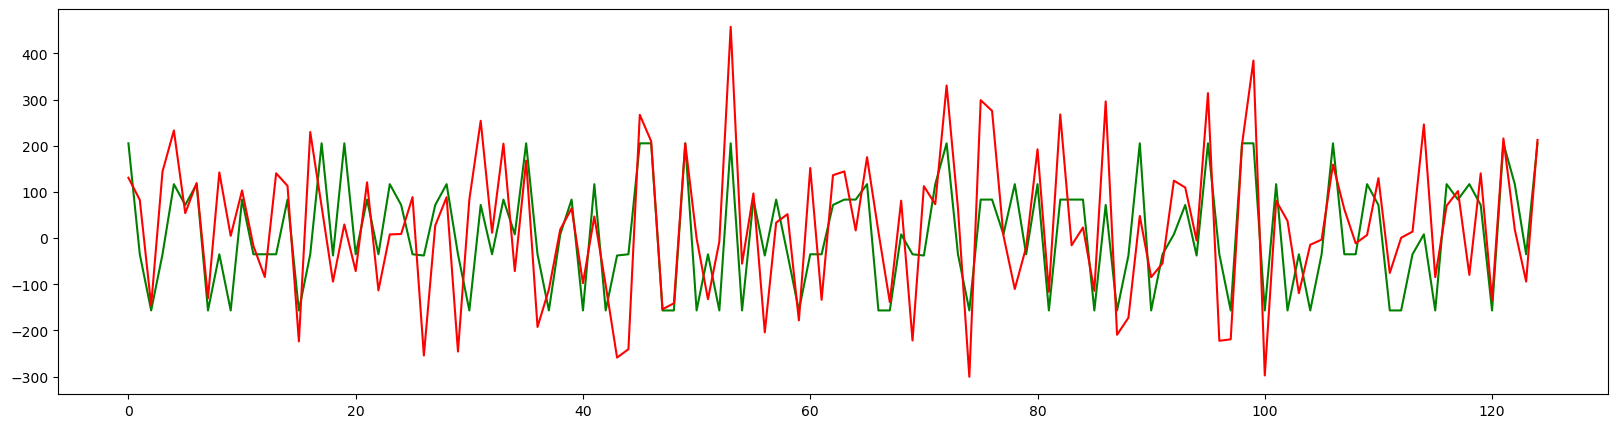

In [633]:
plt.figure(figsize=(20,5))
plt.plot(x, pred2, color='g')
plt.plot(x, y_test, color ='r')
plt.show()

In [574]:
from sklearn.metrics import r2_score

print(r2_score(y_test), r2_score(y_test, pred) )

TypeError: missing a required argument: 'y_pred'

In [87]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

In [634]:
class DecisionTreeRegressorFromScratch:
    def __init__(self, max_depth=20, min_samples_leaf=1):
        self.tree_ = {}
        self.max_depth_ = max_depth

    def mse(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def fit(self, X, y, tree_path='0'):
        # Decide if we should stop growing the tree

        if len(tree_path) - 1 == self.max_depth_ or X.shape[0] <= 1:
            self.tree_[tree_path] = np.mean(y)
            return

        minimum_mse = None
        best_split = None
        for feature in range(X.shape[1]):
            for value in sorted(set(X[:, feature])):

                less_than_or_equal_obs = X[:, feature] <= value # select observations 
                                            # which are less than or equal to value

                # one part are observations which are less than or equal to this value
                X1, y1 = X[less_than_or_equal_obs], y[less_than_or_equal_obs]

                # second part are the others                                                          
                X2, y2 = X[~less_than_or_equal_obs], y[~less_than_or_equal_obs]

                # Calculate weighted MSE for a split
                MSE1 = self.mse(y1, np.mean(y1))
                MSE2 = self.mse(y2, np.mean(y2))
                weight_1 = len(y1) / len(y) 
                weight_2 = len(y2) / len(y)
                weighted_mse = MSE1 * weight_1 + MSE2 * weight_2

            # Update MSE
                if minimum_mse is None or weighted_mse < minimum_mse:
                    minimum_mse = weighted_mse
                    best_split = (feature, value)
        # Get samples with best split
        feature, value = best_split
        splitting_condition = X[:, feature] <= value
        X1, y1, X2, y2 = X[splitting_condition], y[splitting_condition],\
                          X[~splitting_condition], y[~splitting_condition]

        #  Add the splitting condition to tree
        self.tree_[tree_path] = best_split

        # Continue growing the tree
        self.fit(X1, y1, tree_path=tree_path + '0')
        self.fit(X2, y2, tree_path=tree_path + '1')

        
    def predict(self, X):
        results = []
        for i in range(X.shape[0]):
            tree_path = '0'
            while True:
                value_for_path = self.tree_[tree_path]
                if type(value_for_path) != tuple:
                    result = value_for_path
                    break
                feature, value = value_for_path
                if X[i, feature] <= value:
                    tree_path += '0'
                else:
                    tree_path += '1' 
            results.append(result)
        return np.array(results)

In [637]:
tree = DecisionTreeRegressorFromScratch()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
r2_score(y_test, y_pred)

0.46596839975030035

In [636]:
print(r2_score(y_test, predicted), r2_score(y_test, pred), r2_score(y_test, y_pred) )

ValueError: Found input variables with inconsistent numbers of samples: [125, 13]

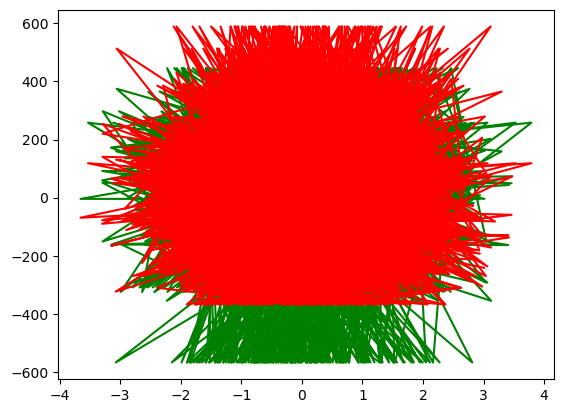

In [90]:
plt.plot(X_test, y_pred, color='g')
plt.plot(X_test, y_test, color ='r')
plt.show()

In [348]:
model = neigh.fit(X_train, y_train)

In [352]:
model.predict([X_test[0]])

array([-15.14774316])

In [351]:
X_test

array([[ 0.19313908, -0.26525366],
       [ 1.40255387, -0.69554481],
       [ 0.08528481,  0.9823901 ],
       [-1.9649488 , -0.26174085],
       [-3.56657912,  0.37664609],
       [-0.67761895,  0.59298238],
       [ 0.44017929, -0.64055997],
       [ 0.02046938,  0.67080029],
       [ 0.94871177,  0.4211698 ],
       [ 0.43912539,  1.00894572],
       [-0.20245773, -1.23297573],
       [-1.56011241, -0.71164467],
       [ 0.78675843,  0.66059072]])